In [1]:
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer
import gc

TEST_SET_THRESHOLD = 10
TEST_SET_HOLDOUT = 0.2
BEST_ALFA = 0.92

In [3]:
import utils

In [4]:
tracks = pd.read_csv('../input/tracks.csv')
train = pd.read_csv('../input/train.csv')
target = pd.read_csv('../input/target_playlists.csv')

In [5]:
icm_csr = utils.build_icm_csr(tracks)
urm_csr = utils.build_urm_csr(train)

/home/antonio/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [6]:
urm_csr = utils.build_urm_csr(train)

In [7]:
from Notebooks_utils.data_splitter import train_test_holdout

URM_train, URM_test = train_test_holdout(urm_csr, train_perc = 0.8)
URM_train, URM_validation = train_test_holdout(URM_train, train_perc = 0.9)

In [8]:
URM_train

<50446x20635 sparse matrix of type '<class 'numpy.float32'>'
	with 872444 stored elements in Compressed Sparse Row format>

In [9]:
URM_test

<50446x20635 sparse matrix of type '<class 'numpy.float32'>'
	with 242721 stored elements in Compressed Sparse Row format>

In [10]:
URM_validation

<50446x20635 sparse matrix of type '<class 'numpy.float32'>'
	with 96626 stored elements in Compressed Sparse Row format>

In [11]:
from scipy.sparse import find, csr_matrix

nnz_per_row = URM_test.getnnz(axis=1)
result = np.where(nnz_per_row > 0)[0]

test_playlists = result

In [12]:
len(test_playlists)

47485

In [13]:
from Base.Evaluation.Evaluator import SequentialEvaluator

In [14]:
evaluator = SequentialEvaluator(URM_validation,cutoff_list=[10])
recommender = SLIM_BPR_Cython(URM_train,recompile_cython=False,positive_threshold=1) 

SLIM_BPR_Cython: Estimated memory required for similarity matrix of 20635 items is 1703.21 MB


In [15]:
batches = [1,2,5,10,50,100]
ks = [10,25,50,75,80,100,500,1000]
MAPS = []
for batch in batches:
    for k in ks:
        print("TRAINING with {} batchs and top {}".format(batch,k))
        evaluator = SequentialEvaluator(URM_validation,cutoff_list=[10])
        recommender = SLIM_BPR_Cython(URM_train,recompile_cython=False,positive_threshold=1) 
        recommender.fit(epochs=50,batch_size=batch,sgd_mode='adam',learning_rate=1e-4,topK=k)
        gc.collect()
        datas,_ = evaluator.evaluateRecommender(recommender)
        MAP = datas[10]['MAP']
        MAPS.append([batch,k,MAP])
        print("*****RESULT with {} batchs and top {} is MAP = {}".format(batch,k,MAP))
        gc.collect()

TRAINING with 1 batchs and top 10
SLIM_BPR_Cython: Estimated memory required for similarity matrix of 20635 items is 1703.21 MB
Processed 872444 ( 100.00% ) in 2.68 seconds. BPR loss is 5.98E-03. Sample per second: 325325
SLIM_BPR_Recommender: Epoch 1 of 50. Elapsed time 0.10 min
Processed 872444 ( 100.00% ) in 3.17 seconds. BPR loss is 2.27E-02. Sample per second: 275059
SLIM_BPR_Recommender: Epoch 2 of 50. Elapsed time 0.14 min
Processed 872444 ( 100.00% ) in 2.91 seconds. BPR loss is 4.20E-02. Sample per second: 299512
SLIM_BPR_Recommender: Epoch 3 of 50. Elapsed time 0.18 min
Processed 872444 ( 100.00% ) in 3.61 seconds. BPR loss is 6.41E-02. Sample per second: 241645
SLIM_BPR_Recommender: Epoch 4 of 50. Elapsed time 0.23 min
Processed 872444 ( 100.00% ) in 3.35 seconds. BPR loss is 8.78E-02. Sample per second: 260395
SLIM_BPR_Recommender: Epoch 5 of 50. Elapsed time 0.27 min
Processed 872444 ( 100.00% ) in 2.89 seconds. BPR loss is 1.14E-01. Sample per second: 301568
SLIM_BPR_Reco

In [26]:
import itertools
import operator

ordered_maps = sorted(MAPS,key=operator.itemgetter(2))
ordered_maps

[[10, 10, 0.063531907491871098],
 [5, 10, 0.063626730231526971],
 [50, 10, 0.063677377261344967],
 [2, 10, 0.063769486654787738],
 [1, 10, 0.063854984311262103],
 [100, 10, 0.063863470270980563],
 [50, 1000, 0.064940992509334508],
 [5, 1000, 0.064944386405864044],
 [100, 1000, 0.064955251260155222],
 [10, 1000, 0.065024402195179742],
 [2, 1000, 0.065122328473252486],
 [1, 1000, 0.065138212192007314],
 [100, 500, 0.06590643125037951],
 [1, 500, 0.065978457359325435],
 [10, 500, 0.066004100533726892],
 [50, 500, 0.066013224135587967],
 [5, 500, 0.066079289411633602],
 [2, 500, 0.066134619834126607],
 [50, 25, 0.068035075639945167],
 [5, 25, 0.068069524063908801],
 [2, 25, 0.068091206796115869],
 [1, 25, 0.068103951754497599],
 [100, 25, 0.068117238151336093],
 [10, 25, 0.068193485876917717],
 [10, 75, 0.068595397191262952],
 [5, 80, 0.068605093290341715],
 [100, 75, 0.068612812177140395],
 [1, 75, 0.068629190395147671],
 [50, 100, 0.068639672462602122],
 [50, 80, 0.068647078870181649],
 

In [24]:
print(list(grops(MAPS)))

[(1, <itertools._grouper object at 0x7fc033746710>), (2, <itertools._grouper object at 0x7fc033746978>), (5, <itertools._grouper object at 0x7fc033746cf8>), (10, <itertools._grouper object at 0x7fc033746a20>), (50, <itertools._grouper object at 0x7fc0337466a0>), (100, <itertools._grouper object at 0x7fc033746c18>)]


In [27]:
recommender.fit(epochs=100, batch_size=10,sgd_mode='adam',learning_rate=1e-4,topK=50)

Processed 872444 ( 100.00% ) in 2.62 seconds. BPR loss is 6.02E-03. Sample per second: 332685
SLIM_BPR_Recommender: Epoch 1 of 100. Elapsed time 0.10 min
Processed 872444 ( 100.00% ) in 3.21 seconds. BPR loss is 2.28E-02. Sample per second: 271605
SLIM_BPR_Recommender: Epoch 2 of 100. Elapsed time 0.14 min
Processed 872444 ( 100.00% ) in 2.79 seconds. BPR loss is 4.24E-02. Sample per second: 312690
SLIM_BPR_Recommender: Epoch 3 of 100. Elapsed time 0.18 min
Processed 872444 ( 100.00% ) in 3.31 seconds. BPR loss is 6.44E-02. Sample per second: 263742
SLIM_BPR_Recommender: Epoch 4 of 100. Elapsed time 0.23 min
Processed 872444 ( 100.00% ) in 2.85 seconds. BPR loss is 8.85E-02. Sample per second: 305942
SLIM_BPR_Recommender: Epoch 5 of 100. Elapsed time 0.27 min
Processed 872444 ( 100.00% ) in 3.41 seconds. BPR loss is 1.15E-01. Sample per second: 255992
SLIM_BPR_Recommender: Epoch 6 of 100. Elapsed time 0.31 min
Processed 872444 ( 100.00% ) in 2.96 seconds. BPR loss is 1.43E-01. Sample p

In [28]:
recommender.compute_item_score(7).sum()

241.73265

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer

TEST_SET_THRESHOLD = 10
TEST_SET_HOLDOUT = 0.2
BEST_ALFA = 0.92

In [30]:
class EnsembleRecommender(object):
    
    def get_URM_train(self):
        return self.URM_csr.copy()
    
    def fit(self,slim_recommender, URM_csr, ICM_csr, alfa, beta):
        self.beta = beta
        self.slim_recommender = slim_recommender
        transformer = TfidfTransformer()
        transformer.fit(URM_csr)
        tf_idf_csr = transformer.transform(URM_csr)

        IRM = sparse.csr_matrix(tf_idf_csr.transpose())
        
        csr_similarities = sparse.csr_matrix(cosine_similarity(IRM, dense_output=False))
        

        transformer.fit(ICM_csr)
        tf_idf_icm = transformer.transform(ICM_csr)
        icm_similarities = sparse.csr_matrix(cosine_similarity(tf_idf_icm, dense_output=False))
        
        print("COMPUTING ENSEMBLE SIMILARITIES")
        self.item_similarities = alfa*csr_similarities + (1-alfa)*icm_similarities        
        self.URM_csr = URM_csr
        
    
    def recommend(self, user_id, cutoff=10, remove_seen_flag=True):
        
        
        user = self.URM_csr.getrow(user_id)
        itemPopularity = user.dot(self.item_similarities)
        slimPopularity = self.slim_recommender.compute_item_score(user_id)
        item_popularity = itemPopularity*self.beta + slimPopularity*(1-self.beta)
        popularItems = np.argsort(np.array(item_popularity)[0])
        popularItems = np.flip(popularItems, axis = 0)

        if remove_seen_flag:
            unseen_items_mask = np.in1d(popularItems, self.URM_csr[user_id].indices,
                                        assume_unique=True, invert = True)

            unseen_items = popularItems[unseen_items_mask]
            
            recommended_items = unseen_items[0:cutoff]

        else:
            recommended_items = popularItems[0:cutoff]
            
        #recommended_items = " ".join(str(i) for i in recommended_items)
        return recommended_items
    
    

In [31]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def MAP(recommended_items, relevant_items):
       
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score


def evaluate_algorithm(URM_test, recommender_object, target_playlists, at=10):
    
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    result = []
    
    for user_id in target_playlists:
    
        target_items = URM_test.getrow(user_id).indices
        
        recommended_items = recommender_object.recommend(user_id, cutoff=at)
        num_eval+=1
        
        cumulative_precision += precision(recommended_items, target_items)
        cumulative_recall += recall(recommended_items, target_items)
        cumulative_MAP += MAP(recommended_items, target_items)
        
        recommendation_string = " ".join(str(i) for i in recommended_items)
        temp = [user_id,recommendation_string]
        result.append(temp)


    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    return cumulative_MAP
    
 

In [32]:
gc.collect()

0

In [34]:
alphas = [0.6,0.7,0.75,0.80, 0.90, 0.92, 0.95]
betas = [0,0.1,0.25,0.5,0.6,0.75,0.8,0.85,0.88,0.9,0.92,0.95,1]
MAPS = []
for alpha in alphas:
    for beta in betas:
        ensemble_recommender = EnsembleRecommender()
        ensemble_recommender.fit(recommender,URM_train,icm_csr,alpha,beta)
        gc.collect()
        map = evaluate_algorithm(URM_test,ensemble_recommender,test_playlists)
        MAPS.append([alpha,beta,map])
        print("*****RESULT with {} alpha and beta {} is MAP = {}".format(alpha,beta,map))
        gc.collect()

COMPUTING ENSEMBLE SIMILARITIES
*****RESULT with 0.6 alpha and beta 0 is MAP = 0.08213096711489166
COMPUTING ENSEMBLE SIMILARITIES
*****RESULT with 0.6 alpha and beta 0.1 is MAP = 0.08462027727431302
COMPUTING ENSEMBLE SIMILARITIES
*****RESULT with 0.6 alpha and beta 0.25 is MAP = 0.0886312848545667
COMPUTING ENSEMBLE SIMILARITIES
*****RESULT with 0.6 alpha and beta 0.5 is MAP = 0.09513471351749692
COMPUTING ENSEMBLE SIMILARITIES
*****RESULT with 0.6 alpha and beta 0.6 is MAP = 0.09737033451878915
COMPUTING ENSEMBLE SIMILARITIES
*****RESULT with 0.6 alpha and beta 0.75 is MAP = 0.09976024376012961
COMPUTING ENSEMBLE SIMILARITIES
*****RESULT with 0.6 alpha and beta 0.8 is MAP = 0.09941426369197849
COMPUTING ENSEMBLE SIMILARITIES
*****RESULT with 0.6 alpha and beta 0.85 is MAP = 0.09825409416396307
COMPUTING ENSEMBLE SIMILARITIES
*****RESULT with 0.6 alpha and beta 0.88 is MAP = 0.09704791230700932
COMPUTING ENSEMBLE SIMILARITIES
*****RESULT with 0.6 alpha and beta 0.9 is MAP = 0.0958161

In [1]:
MAPS

NameError: name 'MAPS' is not defined

In [20]:
target = target.get_values()[:,0]

In [21]:
n = 500
  
# using list comprehension 
divided_target = [target[i * n:(i + 1) * n] for i in range((len(target) + n - 1) // n )]  

In [22]:
result = []
for items in target:
    partial_recomendations = ensemble_recommender.recommend(items,cutoff=10)
    result.append(partial_recomendations)

In [23]:
result = np.array(result)

In [24]:
result.reshape(-1,10)

array([[17154, 14765,  8749, ..., 20443,  4603, 13542],
       [ 4202,   699,  7545, ...,  1713,  5620, 11943],
       [ 8001,  2159, 15341, ...,  9231,  1944,    56],
       ..., 
       [ 4986, 18956, 18287, ..., 20135,  4476, 10806],
       [14907,  4774,  8880, ..., 10786,  4148,  1898],
       [ 6492, 19152, 18254, ..., 13456, 16756,  7931]])

In [25]:
result = result.reshape(-1,10)

In [26]:
result.shape

(10000, 10)

In [27]:
i = 0
results = []
for item in result:
    recommended_items = " ".join(str(i) for i in item)
    temp = [target[i],recommended_items]
    results.append(temp)
    i += 1

In [28]:
rec = pd.DataFrame(results)
rec.to_csv("submission_ensemble.csv", index = False, header = ["playlist_id", "track_ids"])

In [121]:
MAPS_per_alpha = []
for i in range(4):
    temp = MAPS[10*i:10+10*i]
    MAPS_per_alpha.append([alphas[i],temp])

In [108]:
MAPS_per_beta = []
for i in range(10):
    indexes = [0+i,10+i,20+i,30+i]
    temps = []
    for j in indexes:
        temps.append(MAPS[j])
    MAPS_per_beta.append([betas[i],temps])

[9, 19, 29, 39]

40

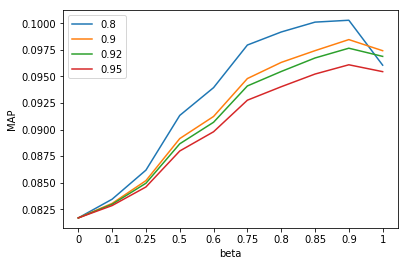

In [128]:

import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(MAPS_per_alpha[0][1], label=alphas[0])
pyplot.plot(MAPS_per_alpha[1][1], label=alphas[1])
pyplot.plot(MAPS_per_alpha[2][1], label=alphas[2])
pyplot.plot(MAPS_per_alpha[3][1], label=alphas[3])
pyplot.xticks([0,1,2,3,4,5,6,7,8,9], betas)
pyplot.ylabel('MAP')
pyplot.xlabel('beta')
pyplot.legend()
pyplot.show()

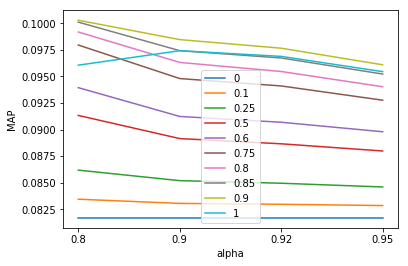

In [127]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(MAPS_per_beta[0][1], label=betas[0])
pyplot.plot(MAPS_per_beta[1][1], label=betas[1])
pyplot.plot(MAPS_per_beta[2][1], label=betas[2])
pyplot.plot(MAPS_per_beta[3][1], label=betas[3])
pyplot.plot(MAPS_per_beta[4][1], label=betas[4])
pyplot.plot(MAPS_per_beta[5][1], label=betas[5])
pyplot.plot(MAPS_per_beta[6][1], label=betas[6])
pyplot.plot(MAPS_per_beta[7][1], label=betas[7])
pyplot.plot(MAPS_per_beta[8][1], label=betas[8])
pyplot.plot(MAPS_per_beta[9][1], label=betas[9])
pyplot.xticks([0,1,2,3], alphas)
pyplot.ylabel('MAP')
pyplot.xlabel('alpha')
pyplot.legend()
pyplot.show()

In [17]:
recommender.fit(epochs=150, batch_size=5,sgd_mode='adam',learning_rate=1e-4,topK=80)

Processed 1211791 ( 100.00% ) in 5.24 seconds. BPR loss is 3.16E-02. Sample per second: 231412
SLIM_BPR_Recommender: Epoch 1 of 150. Elapsed time 0.15 min
Processed 1211791 ( 100.00% ) in 5.19 seconds. BPR loss is 1.16E-01. Sample per second: 233509
SLIM_BPR_Recommender: Epoch 2 of 150. Elapsed time 0.23 min
Processed 1211791 ( 100.00% ) in 5.27 seconds. BPR loss is 2.13E-01. Sample per second: 230045
SLIM_BPR_Recommender: Epoch 3 of 150. Elapsed time 0.31 min
Processed 1211791 ( 100.00% ) in 5.28 seconds. BPR loss is 3.21E-01. Sample per second: 229587
SLIM_BPR_Recommender: Epoch 4 of 150. Elapsed time 0.40 min
Processed 1211791 ( 100.00% ) in 5.32 seconds. BPR loss is 4.43E-01. Sample per second: 227871
SLIM_BPR_Recommender: Epoch 5 of 150. Elapsed time 0.48 min
Processed 1211791 ( 100.00% ) in 5.42 seconds. BPR loss is 5.74E-01. Sample per second: 223423
SLIM_BPR_Recommender: Epoch 6 of 150. Elapsed time 0.57 min
Processed 1211791 ( 100.00% ) in 5.42 seconds. BPR loss is 7.15E-01. S

In [19]:
ensemble_recommender = EnsembleRecommender()
ensemble_recommender.fit(recommender,urm_csr,icm_csr,alfa = 0.8,beta = 0.9)

COMPUTING ENSEMBLE SIMILARITIES


In [ ]:
ensemble_recommender